In [2]:
%matplotlib inline
import math
import pandas as pd
import pylab as p
alpha = 0.05
unordered_nominal_columns = ['Most_Important_Issue', 'Main_transportation', 'Occupation']


def convert_to_bool(df, *column_names):
    for column_name in column_names:
        df[column_name] = df[column_name].map(lambda x: 1 if x == "Yes" else (0 if x == 'No' else None))


def identify_and_set_correct_types(df):
    # boolean columns: Looking_at_poles_results Married Will_vote_only_large_party Financial_agenda_matters Voting_Time Gender
    convert_to_bool(df, 'Looking_at_poles_results', 'Married', 'Will_vote_only_large_party', 'Financial_agenda_matters')
    df['Gender'] = df['Gender'].map(lambda x: 1 if x == 'Male' else (0 if x == 'Female' else None))

    # Ordered nominal columns: Age_group
    df['Age_group'] = df['Age_group'].map(lambda x: 1 if x == "Below_30" else (2 if x == "30-45" else (3 if x == "45_and_up" else None)))
    df['Age_group'] = df['Age_group'].astype('category', ordered=True)
    df['Voting_Time'] = df['Voting_Time'].map(lambda x: 1 if x == 'By_16:00' else (2 if x == 'After_16:00' else None))
    df['Voting_Time'] = df['Voting_Time'].astype('category', ordered=True)

#     for col in unordered_nominal_columns:
#         df[col] = df[col].astype('category', ordered=False)

    return df


def nominal_to_numeric(df):
    # we are losing the missing data here
    for col in unordered_nominal_columns:
        partial = pd.get_dummies(df[col], col, '_')
        df = df.join(partial)
        del df[col]
    return df


def print_missing_values(df):
    print '\n\nMissing values:'
    for col in df.columns.values:
        misCount = df[col].isnull().sum()
        if misCount > 0:
            print '%s: %s missing values' % (col, misCount)

def plot_log_density_function(df, column):
    plot_density_function(df, column, lambda x: math.log(x))


def plot_density_function(df, column, trans=lambda x: x):
    df[column].plot(kind='kde')    
    # p.savefig('foo.png')
    # p.clf()
    p.show()


In [ ]:
df = pd.read_csv('./dataset/ElectionsData.csv')
# df = identify_and_set_correct_types(df)
df.dropna(inplace=True)
df.describe()


#### Remove not possible values

In [ ]:
df=df[df['Avg_monthly_expense_when_under_age_21']>=0]
df=df[df['AVG_lottary_expanses']>=0]
df.describe()

In [ ]:
import numpy as np
# Identify which of the orginal features are objects
ObjFeat=df.keys()[df.dtypes.map(lambda x: x=='object')]

# Transform the original features to categorical
# Creat new 'int' features, resp.

for f in ObjFeat:
    df[f] = df[f].astype("category")
    df[f+"Int"] = df[f].cat.rename_categories(range(df[f].nunique())).astype(int)
    df.loc[df[f].isnull(), f+"Int"] = np.nan #fix NaN conversion
    df[f]=df[f+"Int"]
    del df[f+"Int"]

In [ ]:
df.info()

### Convert to Numpy array

In [ ]:
df_X_noNaN = df.drop(['Vote'], axis=1).values
df_Y_noNaN = df.Vote.values

## Filters (Features Selection)

In [ ]:
all_features = list(df.columns)
all_features.remove('Vote')
features_to_keep=[]

### Applying chi2 for nominal values:

In [ ]:
from sklearn.feature_selection import chi2
v=chi2(df_X_noNaN, df_Y_noNaN)[1]
i=0
for c in all_features:
    if c in ObjFeat:
        print  str(v[i]) +": " + c
        if v[i]<alpha:
            features_to_keep.append(c)            
    i+=1

In [ ]:
features_to_keep

### Now we would like to apply ANOVA for the numeric values
but there are 2 assumptions:
- The distribution in each group is normal.
- The variance in each group is the same.

#### Testing for normal distribution:

In [ ]:
from scipy.stats import shapiro
# print('scipy:', scipy.__version__)
i=0
not_normal =[]
for c in all_features:
    if c not in ObjFeat:
        #lets test for normal distribution
        v=shapiro(df[c])[1]
        print str(v) + ": " + c
        if v>0:
            not_normal.append(c)            
            plot_density_function(df,c)
    i+=1

Looking at the distribution functions for the not normally distributed features, we see they are uniformly distributed, so let's transform them to normal distribution.

In [ ]:
from scipy.stats import norm 
dfNormal = df.copy()
zero_to_one = [f for f in not_normal if dfNormal[f].min()>0 and dfNormal[f].min()<0.001 and dfNormal[f].max()<1 and dfNormal[f].max()>0.999]
zero_to_ten = [f for f in not_normal if dfNormal[f].min()>0 and dfNormal[f].min()<0.01 and dfNormal[f].max()<10 and dfNormal[f].max()>9.99]
zero_to_hundred = [f for f in not_normal if dfNormal[f].min()>0 and dfNormal[f].min()<0.1 and dfNormal[f].max()<100 and dfNormal[f].max()>99.9]
for f in not_normal:    
    min= 0 if f in zero_to_one or f in zero_to_ten or f in zero_to_hundred else dfNormal[f].min()
    max= 1 if f in zero_to_one else (10 if f in zero_to_ten else 100 if f in zero_to_hundred else dfNormal[f].max())
#     print f + " max: "+str(max) + " min: " +str(min) + " max-min: " + str(max-min)
    dfNormal[f+"Normal"] = dfNormal[f].map(lambda x: norm.ppf((x-min)/(max-min)))     


In [ ]:
dfNormal.head()

#### getting rid of infinite values, we can't handle them, so we'll use the next best thing

In [ ]:
dfNormal.replace([np.inf,-np.inf], np.nan, inplace=True)
dfNormal.dropna(inplace=True)

In [ ]:
from scipy.stats import shapiro
i=0
not_normal =[]
for c in dfNormal.columns:    
    if c not in ObjFeat:
        #lets test for normal distribution        
        v=shapiro(dfNormal[c])[1]
        print str(v) + ": " + c
        if v>0:
            not_normal.append(c)                       
    i+=1

In [ ]:
#what about the second assumption: The variance in each group is the same?
for vote in df.Vote.unique():
    print str(vote) + ":"  + str(df[df.Vote==vote]['Yearly_IncomeK'].var())
#or is it really the hipothesis and not an assumption? we should email him to understand if there's an error in the slides
#lets ignore it for now

In [ ]:
df_X_normal_dis_noNaN = dfNormal.drop(['Vote'], axis=1).values
df_Y_normal_dis_noNaN = dfNormal.Vote.values

In [ ]:
import sklearn
v=sklearn.feature_selection.f_classif(df_X_normal_dis_noNaN, df_Y_normal_dis_noNaN)[1]
i=0
for c in dfNormal.drop(['Vote'], axis=1).columns:
    if c not in ObjFeat:        
        print  str(v[i]) + ": " + c
        if v[i]<alpha: #what is the null hipothesis? should we keep features with low value or high value?
            features_to_keep.append(c)            
    i+=1
    


In [ ]:
features_to_keep

All the features that were uniformly distributed seem insignificant by this test, did we do anything wrong? 
Lets print their mean by vote:

In [ ]:
votes=df.Vote.unique()
votes.sort()

for c in df.columns:
    if c in not_normal:
        print c
        for vote in votes:                                
            print str(vote) + ": "  + str(df[df.Vote==vote][c].mean())

None of them seem meaningful

What to do next:
- find more insights like this -> more meaningful features
- Maybe find more tests (we could leave it for later) 
- Find features that are highly related to each other (same way we found features that are highly related to the label). Then maybe for each group, find the one that is most significant to the label, and use wrapper method to see if removing the others decrease performance of different classifiers.

### Comparing KDE's between classes:

In [ ]:
discrete_features = [c for c in df.columns if len(df[c].unique())<=20 and c!='Vote'] # nominal features and some numeric features, like Last_school_grades

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

votes=df.Vote.unique()
votes.sort()

for c in all_features:
    if c not in features_to_keep: #only look at features we still have'nt found any reason to keep    
        if c not in discrete_features: # this is only relevant for non-discrete features
            print c + ": " +  str(c in features_to_keep)
            for vote in votes:                                
                df[df.Vote==vote][c].plot(kind='kde')            
            plt.show()
    

Conclusion: no new evidence to keep one of those features

In [ ]:
for c in df.columns:
    if c in features_to_keep: # lets see if there are redundant features we decided to keep
        if c not in discrete_features: # this is only relevant for non-discrete features
            print c + ": " +  str(c in features_to_keep)
            for vote in votes:                                
                df[df.Vote==vote][c].plot(kind='kde')            
            plt.show()

In [ ]:
#these 2 look the same
df.plot(x='Avg_monthly_expense_when_under_age_21', y='Avg_Residancy_Altitude')

Yes, they are linearly dependent, so we can drop one of them, and even use it to fill the other one's missing data

In [ ]:
features_to_keep

In [ ]:
features_to_keep.remove('Avg_Residancy_Altitude')

In [ ]:
#these two look pretty similar too
df.plot(x='Yearly_ExpensesK', y='Avg_monthly_expense_on_pets_or_plants')

Not sure if thats close enough to drop one of them, let's keep them for now

In [ ]:
for vote in votes:
    df[df.Vote==vote].plot(y='Yearly_ExpensesK', x='Avg_monthly_expense_on_pets_or_plants')

In [ ]:
df.Vote.plot(kind='hist')

In [ ]:
#for discrete features, lets compare histograms of votes between different values
for c in discrete_features:
    print c + ": " +  str(c in features_to_keep)    
    ct = pd.crosstab(df[c], df.Vote)
    ctn=ct.div(ct.sum(axis=1), axis=0).div(ct.sum(axis=0), axis=1) #normalize
    ctn.plot(kind='bar', figsize = (15,5)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()    
    #lets also print the KDEs, maybe it will help    
    if len(df[c].unique())>2:
        for vote in votes:                                        
            df[df.Vote==vote][c].plot(kind='kde')            
    plt.show()

Occupation_Satisfaction- looks different for party 6 when value is 4 and 10, BUT 6 is a very small party, so using this is probably overfitting

Number_of_differnt_parties_voted_for - looks like it does matter, at least for values greater than 4. The qeustion is, do people who voted for a large number of parties tend to vote more for a certain party (party 1 got a very high value with people who voted for 7 different parties) or maybe the histogram looks like this simply because less people have higher values (let's print the histogram), but it doesn't help us predict who will they vote to.
Since the outstanding numbers in the histograms (when exist) are for small parties, and the histograms are very different between the high numbers (the parties with more votes are not consistent) we believe it's just noise.

Num_of_kids_born_last_10_years - same

Last_school_grades - looks like it doesn't matter when 60 or above, we should probably reduce all these values to one. 

In [ ]:
print 'Number_of_differnt_parties_voted_for'
df.Number_of_differnt_parties_voted_for.plot(kind='hist')
plt.show()

print 'Num_of_kids_born_last_10_years'
df.Num_of_kids_born_last_10_years.plot(kind='hist')
plt.show()

So it looks like we were right, and those features are not important, they weren't included anyway.

In [ ]:
df['Last_school_grades'] = df['Last_school_grades'].map(lambda x: 60 if x >= 60 else x)

c = 'Last_school_grades'
ct = pd.crosstab(df[c], df.Vote)
ctn=ct.div(ct.sum(axis=1), axis=0).div(ct.sum(axis=0), axis=1) #normalize
ctn.plot(kind='bar', figsize = (15,5)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()  

## Wrappers (Features Selection)

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold

def wrappersTest(X, Y, kf): 
    classifiers = {
        "Nearest Neighbors": KNeighborsClassifier(15),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(max_depth=5),
        "Perceptron": Perceptron(n_iter=50),
    #     "Linear SVM OVO": SVC(kernel="linear", C=1),
        "Linear SVM OVR": LinearSVC(C=1),
        "Random Forest": RandomForestClassifier(n_estimators = 3)
    }
    res = {}
    for name, clf in classifiers.iteritems():
        score_sum=0 
        print 'start ' + str(name) + ' test..'
        for k, (train_index, test_index) in enumerate(kf):            
            clf.fit(X[train_index], Y[train_index])            
            acc = clf.score(X[test_index],Y[test_index])
            score_sum += acc                 
            print("[fold {0}] {1} score: {2:.5}".format(k, name, acc))
        print("{0} average score: {1:.5}".format(name, score_sum/kf.n_folds))
        res[name] = score_sum/kf.n_folds
    return res

def evaulate_features(df):
    similar_features=['Avg_monthly_expense_when_under_age_21', 'AVG_lottary_expanses', 'Garden_sqr_meter_per_person_in_residancy_area']
    n_folds=5
    kf = KFold(n=len(df), n_folds=n_folds)
    
    res = {}
    print 'Wrappers score with all selected features:'
    res['all'] = wrappersTest(df[features_to_keep].values, df_Y_noNaN, kf)
    
    print 'Wrappers score without similar_features:'
    res['withou similar_features'] = wrappersTest(df[features_to_keep].drop(similar_features, axis=1).values, df_Y_noNaN, kf)

    for s in similar_features:   
        print 'Wrappers score without ' + str(s) + ':'
        res[s] = wrappersTest(df[features_to_keep].drop(s, axis=1).values, df_Y_noNaN, kf)
        
    return res

In [ ]:
pd.DataFrame.from_dict(evaulate_features(df))

### Lets normalize and try again

In [ ]:
df_standard=df[features_to_keep]
for c in df_standard.columns:
    if c not in discrete_features:
        mean = df_standard[c].mean()
        std=df_standard[c].std()
        df_standard[c]=df_standard[c].map(lambda x: (x-mean)/std )

In [ ]:
df_standard.describe()

In [ ]:
pd.DataFrame.from_dict(evaulate_features(df_standard))

## Filling up missing values

In [16]:
df_with_nan = pd.read_csv('./dataset/ElectionsData.csv')

In [17]:
df_with_nan[df_with_nan['Avg_monthly_expense_when_under_age_21'].isnull()]

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,...,Last_school_grades,Age_group,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Overall_happiness_score,Num_of_kids_born_last_10_years,Financial_agenda_matters
305,Oranges,1,NaN,51537.325857,Education,119.161589,No,432.499486,Yes,Male,...,100,45_and_up,2,929.556851,6,Public_or_other,Services_or_Retail,745.886621,2,No
396,Oranges,8,NaN,148937.696289,Social,338.474499,No,440.026343,Yes,Female,...,70,45_and_up,1,958.972272,8,Car,Services_or_Retail,753.924145,0,No
401,Oranges,5,NaN,110071.755884,Healthcare,139.042636,No,791.640315,No,Female,...,80,30-45,4,1186.027289,12,Public_or_other,Public_Sector,688.305892,2,No
414,Greens,1,NaN,19778.667354,Foreign_Affairs,23.363910,No,846.547846,No,Female,...,40,45_and_up,1,994.856171,19,Motorcycle_or_truck,Industry_or_other,489.561663,0,Yes
422,Yellows,8,NaN,94575.998652,Social,247.447853,No,382.205776,Yes,Female,...,70,Below_30,0,829.819311,16,Foot_or_bicycle,Industry_or_other,581.478247,1,No
456,Blues,1,NaN,76546.352571,Education,125.887033,No,608.055897,No,Female,...,100,30-45,3,981.747029,10,Car,Student_or_Unemployed,673.821995,0,No
521,Oranges,3,NaN,47795.791808,Healthcare,109.214413,No,437.632638,Yes,Female,...,80,30-45,2,935.517390,10,Motorcycle_or_truck,Industry_or_other,761.644755,1,No
712,Greys,6,NaN,28552.364260,Financial,62.704120,No,455.350686,Yes,Female,...,60,30-45,1,944.213641,1,Motorcycle_or_truck,Industry_or_other,711.017276,0,No
897,Reds,8,NaN,90675.917769,Social,161.602652,No,561.104144,No,Male,...,70,Below_30,2,976.448494,8,Car,Hightech,687.718721,0,No
1278,Greens,8,NaN,225981.062617,Foreign_Affairs,276.842158,No,816.281251,No,Female,...,40,30-45,5,1268.334855,18,Car,Hightech,746.857896,0,Yes


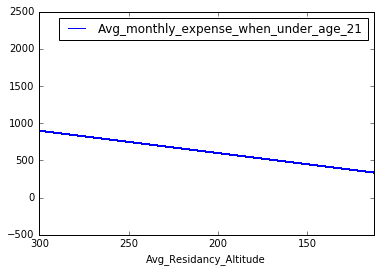

In [18]:
df_with_nan.plot(x='Avg_Residancy_Altitude', y='Avg_monthly_expense_when_under_age_21')

In [19]:
xValues = df_with_nan['Avg_Residancy_Altitude'].values
yValues = df_with_nan['Avg_monthly_expense_when_under_age_21'].values
m = (yValues[0] - yValues[1]) / (xValues[0] - xValues[1])
const = yValues[0] - (m * xValues[0])

def get_avg_monthly_expense_when_under_age_21(avg_Residancy_Altitude_value):
    return const + (m * avg_Residancy_Altitude_value)

def fill_avg_monthly_expense_when_under_age_21(row):
    if row['Avg_Residancy_Altitude'] >=0:
        row['Avg_monthly_expense_when_under_age_21'] = get_avg_monthly_expense_when_under_age_21(row['Avg_Residancy_Altitude'])
    return row

In [20]:
df_with_nan = df_with_nan.apply(fill_avg_monthly_expense_when_under_age_21, axis=1)

In [21]:
df_with_nan[df_with_nan['Avg_monthly_expense_when_under_age_21'].isnull()]

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,...,Last_school_grades,Age_group,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Overall_happiness_score,Num_of_kids_born_last_10_years,Financial_agenda_matters
8087,Yellows,6,NaN,29446.069675,Education,NaN,No,377.806257,Yes,Female,...,100,30-45,1,884.028382,19,Motorcycle_or_truck,Industry_or_other,643.258721,1,No


In [22]:
# now we have Avg_monthly_expense_when_under_age_21 with negative values
df_with_nan[df_with_nan['Avg_monthly_expense_when_under_age_21'] < 0]

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Most_Important_Issue,Avg_Residancy_Altitude,Looking_at_poles_results,Yearly_ExpensesK,Married,Gender,...,Last_school_grades,Age_group,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Overall_happiness_score,Num_of_kids_born_last_10_years,Financial_agenda_matters
256,Purples,5,-100.478824,-21894.875582,Healthcare,-33.492941,Yes,653.716121,No,Female,...,80,30-45,0,1013.004525,8,Public_or_other,Hightech,564.967927,0,Yes
839,Purples,2,-61.756355,-12101.530163,Education,-20.585452,Yes,587.868094,No,Male,...,100,30-45,2,1009.915930,11,Foot_or_bicycle,Student_or_Unemployed,603.419016,0,Yes
930,Purples,7,-83.193224,-9475.644117,Social,-27.731075,Yes,341.697688,Yes,Female,...,70,45_and_up,6,810.515817,12,Public_or_other,Student_or_Unemployed,572.008548,1,Yes
1015,Purples,2,-28.691999,-2855.582077,Education,-9.564000,Yes,298.576135,Yes,Female,...,100,30-45,2,795.482629,20,Car,Student_or_Unemployed,550.631837,0,Yes
1145,Purples,2,-394.030092,-81744.489527,Healthcare,-131.343364,Yes,622.372437,No,Male,...,80,45_and_up,2,1137.635439,20,Motorcycle_or_truck,Industry_or_other,814.592977,4,Yes
2435,Purples,7,-20.878094,-1962.198854,Education,-6.959365,Yes,281.950865,Yes,Female,...,100,45_and_up,1,878.906223,10,Motorcycle_or_truck,Industry_or_other,786.083730,0,Yes
2487,Purples,1,-49.521195,NaN,Social,-16.507065,Yes,603.778519,No,Female,...,70,45_and_up,1,950.700820,15,Motorcycle_or_truck,Student_or_Unemployed,783.358678,1,Yes
2584,Purples,7,-70.286668,-15257.000848,Social,-23.428889,Yes,651.204614,No,Male,...,70,Below_30,3,1100.384348,12,Foot_or_bicycle,Student_or_Unemployed,795.101694,1,Yes
2825,Purples,8,-33.088990,-3469.329493,Education,-11.029663,Yes,314.545368,Yes,Male,...,100,45_and_up,4,1153.156787,7,Car,Industry_or_other,902.472150,0,Yes
3056,Purples,6,-31.832092,-6198.361459,Financial,-10.610697,Yes,584.161549,No,Female,...,60,30-45,2,926.807729,16,Public_or_other,Industry_or_other,781.255300,3,Yes


Should we mark them in nan or remove their row?